#### Chapter 28
### Analyzing Neural Time Series Data
Python code for Chapter 28 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

### Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import detrend
from scipy.stats import zscore, chi2
from armorf import armorf

### Figure 28.1

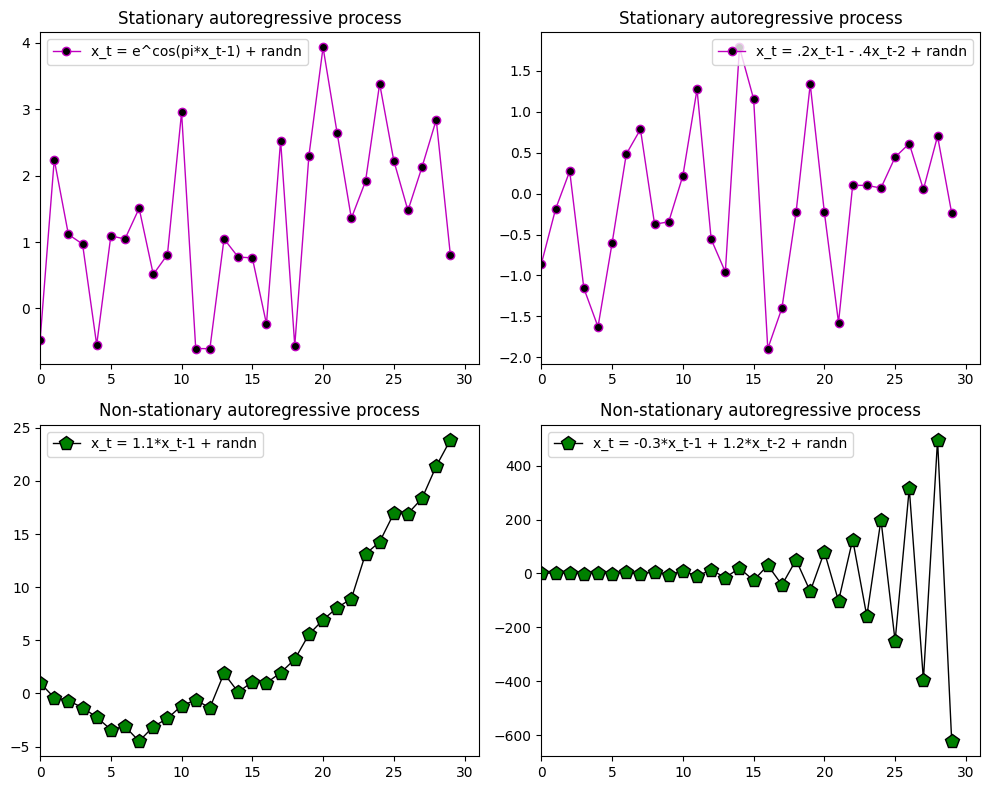

In [2]:
plt.figure(figsize=(10, 8))

# - Stationary-like process - #

x = [np.random.randn()]
for i in range(29):
    x.append(np.exp(np.cos(np.pi * x[i])) + np.random.randn())

plt.subplot(221)
plt.plot(x, 'mo-', linewidth=1, markerfacecolor='k', markersize=6)
plt.xlim([0, 31])
plt.legend(['x_t = e^cos(pi*x_t-1) + randn'])
plt.title('Stationary autoregressive process')

x = [np.random.randn(), np.random.randn()]
for i in range(28):
    x.append(0.2 * x[i+1] - 0.4 * x[i] + np.random.randn())

plt.subplot(222)
plt.plot(x, 'mo-', linewidth=1, markerfacecolor='k', markersize=6)
plt.xlim([0, 31])
plt.legend(['x_t = .2x_t-1 - .4x_t-2 + randn'])
plt.title('Stationary autoregressive process')

# - Non-stationary process - #

x = [1]
for i in range(29):
    x.append(1.1 * x[i] + np.random.randn())

plt.subplot(223)
plt.plot(x, 'kp-', linewidth=1, markerfacecolor='g', markersize=10)
plt.xlim([0, 31])
plt.title('Non-stationary autoregressive process')
plt.legend(['x_t = 1.1*x_t-1 + randn'])

x = [1, 1.5]
for i in range(28):
    x.append(1.2 * x[i] - 0.3 * x[i+1] + np.random.randn())

plt.subplot(224)
plt.plot(x, 'kp-', linewidth=1, markerfacecolor='g', markersize=10)
plt.xlim([0, 31])
plt.legend(['x_t = -0.3*x_t-1 + 1.2*x_t-2 + randn'])
plt.title('Non-stationary autoregressive process')

plt.tight_layout()
plt.show()

### Figure 28.2

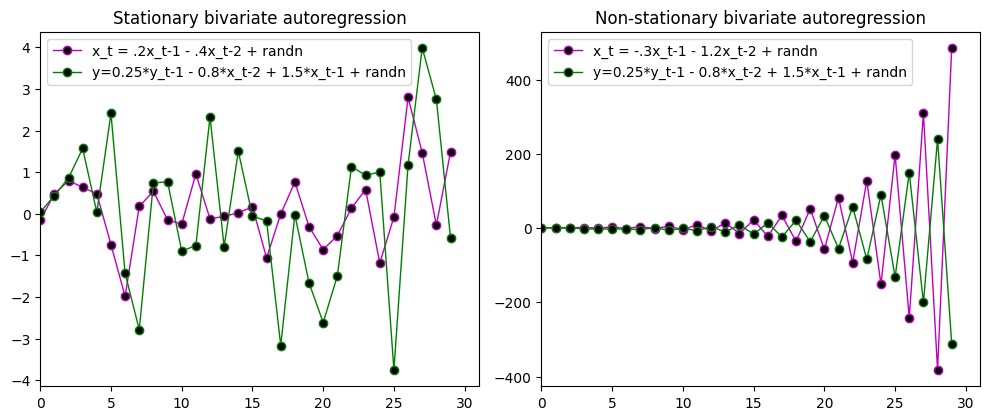

In [3]:
plt.figure(figsize=(10, 8))

# - Stationary-like process - #

# define X
x = [np.random.randn(), np.random.randn()]
for i in range(28):
    x.append(0.2 * x[i+1] - 0.4 * x[i] + np.random.randn())

# define y
y = [np.random.rand(), np.random.rand()]  # random initial conditions
for i in range(len(x)-2):
    y.append(0.25 * y[i+1] - 0.8 * x[i] + 1.5 * x[i+1] + np.random.randn())

plt.subplot(221)
plt.plot(x, 'mo-', linewidth=1, markerfacecolor='k', markersize=6)
plt.plot(y, 'go-', linewidth=1, markerfacecolor='k', markersize=6)
plt.xlim([0, 31])
plt.title('Stationary bivariate autoregression')
plt.legend(['x_t = .2x_t-1 - .4x_t-2 + randn', 'y=0.25*y_t-1 - 0.8*x_t-2 + 1.5*x_t-1 + randn'])

# - Non-stationary process - #

# define X
x = [1, 1.5]
for i in range(28):
    x.append(1.2 * x[i] - 0.3 * x[i+1] + np.random.randn())

# define y
y = [np.random.rand(), np.random.rand()]  # random initial conditions
for i in range(len(x)-2):
    y.append(0.25 * y[i+1] - 1.2 * x[i] + np.random.randn())

plt.subplot(222)
plt.plot(x, 'mo-', linewidth=1, markerfacecolor='k', markersize=6)
plt.plot(y, 'go-', linewidth=1, markerfacecolor='k', markersize=6)
plt.xlim([0, 31])
plt.title('Non-stationary bivariate autoregression')
plt.legend(['x_t = -.3x_t-1 - 1.2x_t-2 + randn', 'y=0.25*y_t-1 - 0.8*x_t-2 + 1.5*x_t-1 + randn'])

plt.tight_layout()
plt.show()

### Figure 28.3

Note: this cell takes a while to run

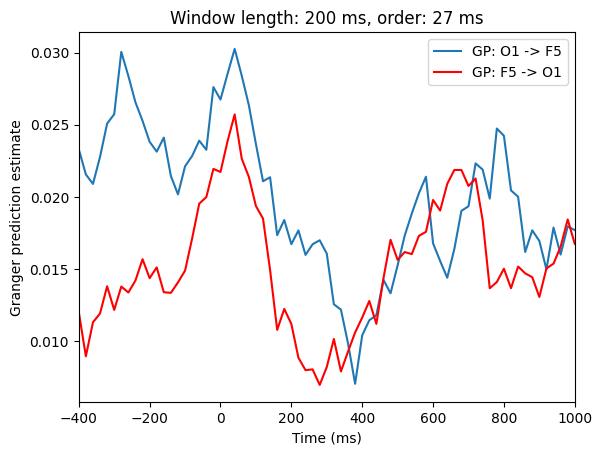

In [4]:
# Load sample EEG data
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

# Define channels for Granger prediction
chan1name = 'O1'
chan2name = 'F5'

# Granger prediction parameters
timewin = 200  # in ms
order = 27  # in ms

# Temporal down-sample results (but not data!)
times2save = np.arange(-400, 1001, 20)  # in ms

# Convert parameters to indices
timewin_points = round(timewin / (1000 / EEG['srate'][0, 0]))
order_points = round(order / (1000 / EEG['srate'][0, 0]))

# Find the index of those channels
chan1 = EEG['chanlocs'][0]['labels'] == chan1name
chan2 = EEG['chanlocs'][0]['labels'] == chan2name

# Remove ERP from selected electrodes to improve stationarity
eegdata = EEG['data'][[np.where(chan1)[0][0], np.where(chan2)[0][0]], :, :] - np.mean(EEG['data'][[np.where(chan1)[0][0], np.where(chan2)[0][0]], :, :], axis=2)[..., np.newaxis]

# Convert requested times to indices
times2saveidx = np.array([np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save])

# Initialize
x2y = np.zeros(len(times2save))
y2x = np.zeros(len(times2save))
bic = np.zeros((len(times2save), 15))  # Bayes info criteria (hard-coded to order=15)

# Loop over time points
for timei in range(len(times2save)):
    # Data from all trials in this time window
    tempdata = eegdata[:, times2saveidx[timei] - timewin_points//2:times2saveidx[timei] + timewin_points//2 - ((timewin_points+1)%2) + 1, :].copy()
    
    # Detrend and zscore all data
    for triali in range(EEG['trials'][0, 0]):
        tempdata[0, :, triali] = zscore(detrend(tempdata[0, :, triali], axis=0), ddof=1, axis=0)
        tempdata[1, :, triali] = zscore(detrend(tempdata[1, :, triali], axis=0), ddof=1, axis=0)

    # Reshape tempdata for VAR
    tempdata = np.reshape(tempdata, (2, timewin_points * EEG['trials'][0][0]), 'F')

    # Fit AR models
    Ax, Ex, _ = armorf(tempdata[0, :][np.newaxis, :], EEG['trials'][0][0], timewin_points, order_points)
    Ay, Ey, _ = armorf(tempdata[1, :][np.newaxis, :], EEG['trials'][0][0], timewin_points, order_points)
    Axy, E, _ = armorf(tempdata, EEG['trials'][0][0], timewin_points, order_points)

    # Compute Granger causality values as log ratio of error variances
    y2x[timei] = np.log(Ex / E[0, 0])
    x2y[timei] = np.log(Ey / E[1, 1])

    # Compute BIC for optimal model order at each time point
    # This code is used for the following cell
    for bici in range(bic.shape[1]):
        # Run model
        Axy, E, _ = armorf(tempdata, EEG['trials'][0][0], timewin_points, bici+1)
        # Computer Bayes Information Criteria
        bic[timei, bici] = np.log(np.linalg.det(E)) + (np.log(len(tempdata[0])) * (bici+1) * 2 ** 2) / len(tempdata[0])

# Plot Granger causality over time
plt.figure()
plt.plot(times2save, x2y, label=f'GP: {chan1name} -> {chan2name}')
plt.plot(times2save, y2x, 'r', label=f'GP: {chan2name} -> {chan1name}')
plt.legend()
plt.title(f'Window length: {timewin} ms, order: {order} ms')
plt.xlim([-400, 1000])
plt.xlabel('Time (ms)')
plt.ylabel('Granger prediction estimate')
plt.show()

### Figure 28.4

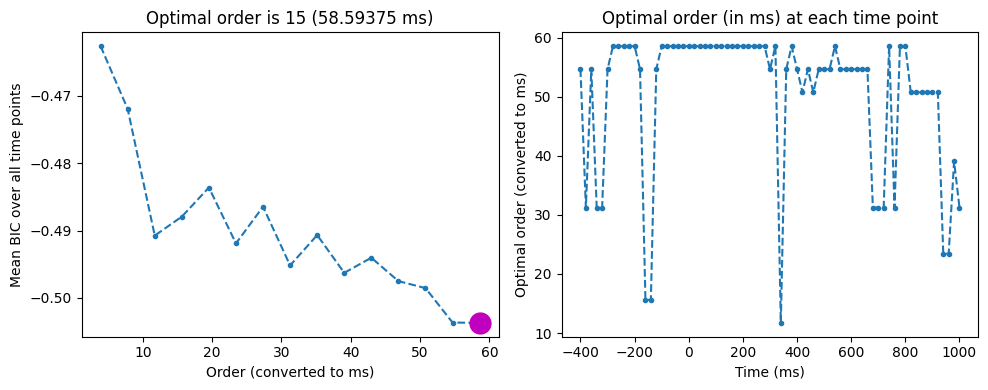

In [5]:
# Plot BIC
plt.figure(figsize=(10, 4))

plt.subplot(121)
mean_bic = np.mean(bic, axis=0)
plt.plot((np.arange(1, bic.shape[1] + 1)) * (1000 / EEG['srate'][0, 0]), mean_bic, '--.')
plt.xlabel('Order (converted to ms)')
plt.ylabel('Mean BIC over all time points')

bestbic_idx = np.argmin(mean_bic) + 1
plt.plot(bestbic_idx * (1000 / EEG['srate'][0, 0]), mean_bic[bestbic_idx-1], 'mo', markersize=15)
plt.title(f'Optimal order is {bestbic_idx} ({bestbic_idx * (1000 / EEG["srate"][0, 0])} ms)')

plt.subplot(122)
bic_per_timepoint = np.argmin(bic, axis=1) + 1
plt.plot(times2save, bic_per_timepoint * (1000 / EEG['srate'][0, 0]), '--.')
plt.xlabel('Time (ms)')
plt.ylabel('Optimal order (converted to ms)')
plt.title('Optimal order (in ms) at each time point')

plt.tight_layout()
plt.show()

### Figure 28.5

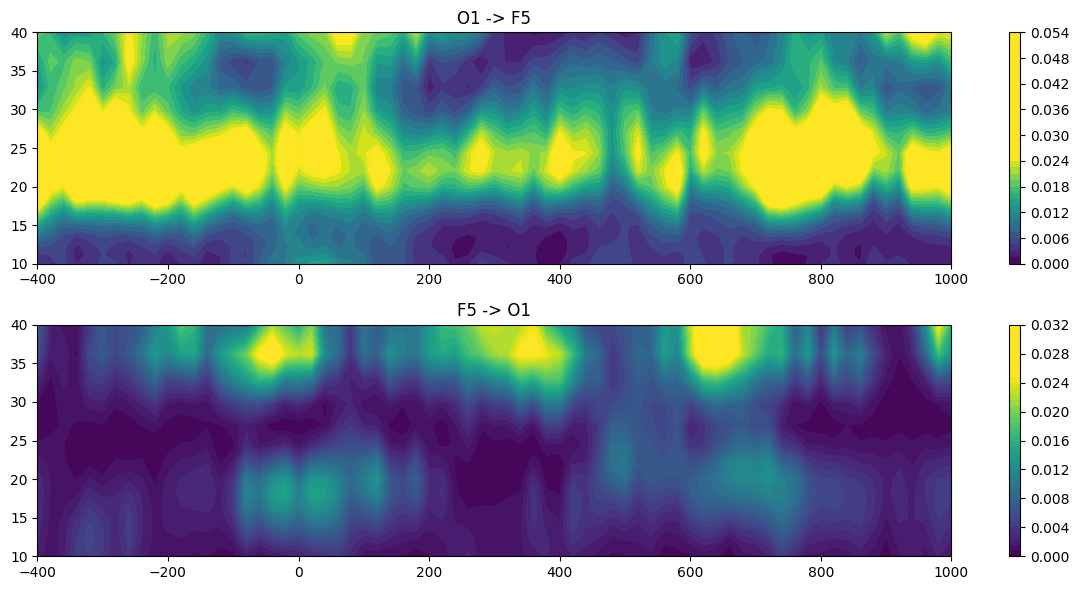

In [6]:
# Define frequency range
min_freq = 10  # in Hz, using a minimum of 10 Hz because of 200-ms window
max_freq = 40

order_points = 15

frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), 15)

# Initialize
tf_granger = np.zeros((2, len(frequencies), len(times2save)))

# Loop over time points
for timei in range(len(times2save)):
    # Data from all trials in this time window
    tempdata = eegdata[:, times2saveidx[timei] - timewin_points//2:times2saveidx[timei] + timewin_points//2 - ((timewin_points+1)%2) + 1, :].copy()

    # Detrend and zscore all data
    for triali in range(EEG['trials'][0, 0]):
        tempdata[0, :, triali] = zscore(detrend(tempdata[0, :, triali], axis=0), ddof=1, axis=0)
        tempdata[1, :, triali] = zscore(detrend(tempdata[1, :, triali], axis=0), ddof=1, axis=0)

    # Reshape tempdata for VAR
    tempdata = np.reshape(tempdata, (2, timewin_points * EEG['trials'][0][0]), 'F')

    # Fit AR models
    Ax, Ex, _ = armorf(tempdata[0, :][np.newaxis, :], EEG['trials'][0][0], timewin_points, order_points)
    Ay, Ey, _ = armorf(tempdata[1, :][np.newaxis, :], EEG['trials'][0][0], timewin_points, order_points)
    Axy, E, _ = armorf(tempdata, EEG['trials'][0][0], timewin_points, order_points)

    # corrected covariance
    eyx = E[1, 1] - E[0, 1]**2/E[0, 0]
    exy = E[0, 0] - E[1, 0]**2/E[1, 1]
    N = len(E)

    # Compute Granger causality for each frequency
    for fi, freq in enumerate(frequencies):
        # Compute the transfer function matrix (Fourier transform of the VAR coefficients)
        H = np.eye(N, dtype=complex)
        for m in range(order_points):
            H += Axy[:, m*N:(m+1)*N] * np.exp(-1j * (m+1) * 2 * np.pi * freq / EEG['srate'][0, 0])

        # Compute the spectral density matrix
        Hi = np.linalg.inv(H)
        S = np.linalg.solve(H, E) @ Hi.T / EEG['srate'][0, 0]

        # Compute Granger causality
        tf_granger[0, fi, timei] = np.log(np.abs(S[1, 1]) / np.abs(S[1, 1] - (Hi[1, 0] * exy * Hi[1, 0].conj()) / EEG['srate'][0, 0]))
        tf_granger[1, fi, timei] = np.log(np.abs(S[0, 0]) / np.abs(S[0, 0] - (Hi[0, 1] * eyx * Hi[0, 1].conj()) / EEG['srate'][0, 0]))

# Plot time-frequency Granger causality
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.contourf(times2save, frequencies, tf_granger[0, :, :], 40, cmap='viridis', vmin=0, vmax=0.025)
plt.colorbar()
plt.title(f'{chan1name} -> {chan2name}')

plt.subplot(212)
plt.contourf(times2save, frequencies, tf_granger[1, :, :], 40, cmap='viridis', vmin=0, vmax=0.025)
plt.colorbar()
plt.title(f'{chan2name} -> {chan1name}')

plt.tight_layout()
plt.show()

### Figure 28.6

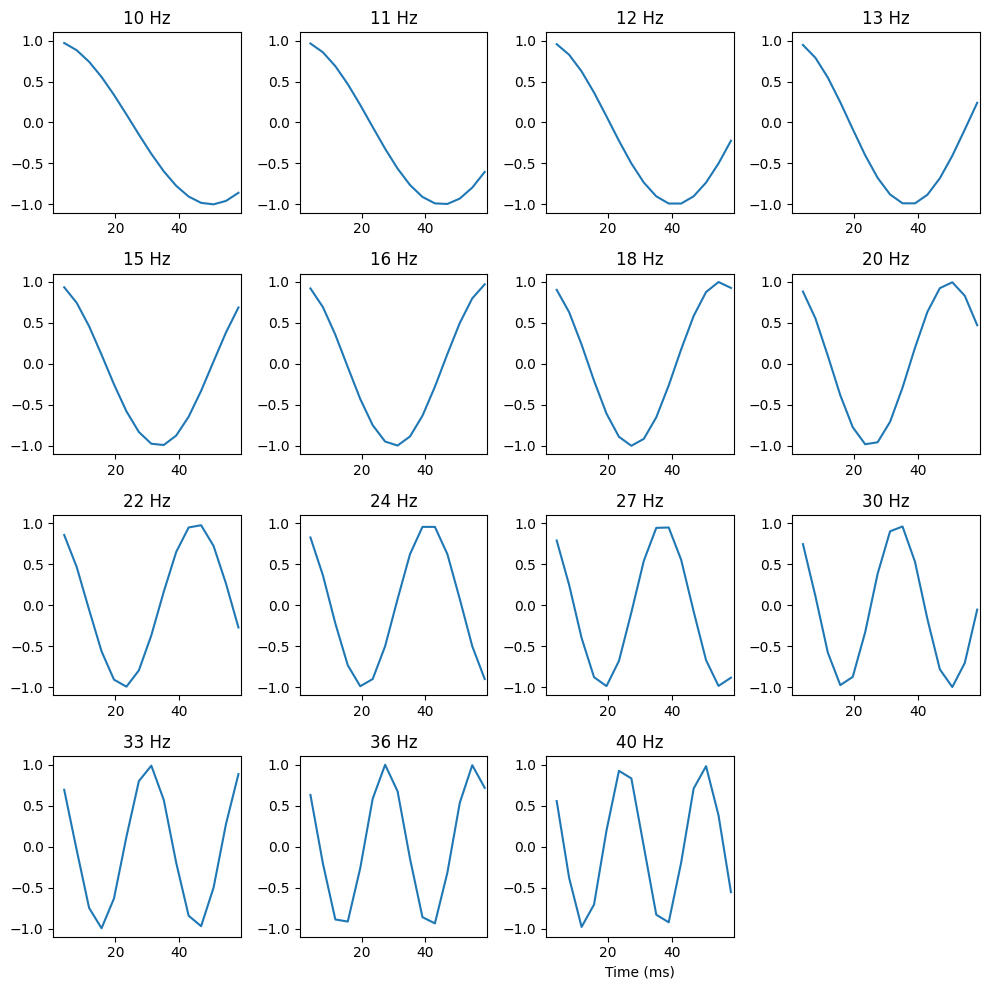

In [7]:
# Plot of cycles per frequency
plt.figure(figsize=(10, 10))
for fi, freq in enumerate(frequencies):
    plt.subplot(4, 4, fi+1)
    cycles = np.real(np.exp(-1j * np.arange(1, order_points+1) * 2 * np.pi * freq / EEG['srate'][0, 0]))
    plt.plot((np.arange(1, order_points+1)) * (1000 / EEG['srate'][0, 0]), cycles)
    plt.xlim([0.5, 1.015 * order_points * (1000 / EEG['srate'][0, 0])])
    plt.ylim([-1.1, 1.1])
    plt.title(f'{round(freq)} Hz')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

### Figure 28.7

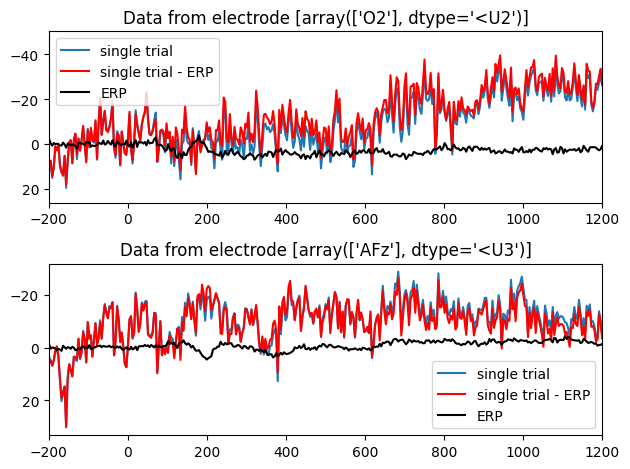

In [8]:
plt.figure()

# Select electrode to plot
electrode2plot = EEG['chanlocs'][0]['labels']=='O2'
erp = np.squeeze(np.mean(EEG['data'][electrode2plot, :, :], axis=2))
plt.subplot(211)
plt.plot(EEG['times'][0], np.squeeze(EEG['data'][electrode2plot, :, 0]),label='single trial')
plt.plot(EEG['times'][0], np.squeeze(EEG['data'][electrode2plot, :, 0]) - erp, 'r', label='single trial - ERP')
plt.plot(EEG['times'][0], erp, 'k', label='ERP')
plt.xlim([-200, 1200])
plt.legend()
plt.title(f'Data from electrode {EEG["chanlocs"][0]["labels"][electrode2plot]}')
plt.gca().invert_yaxis()

# Select another electrode to plot
electrode2plot = EEG['chanlocs'][0]['labels']=='AFz'
erp = np.squeeze(np.mean(EEG['data'][electrode2plot, :, :], axis=2))
plt.subplot(212)
plt.plot(EEG['times'][0], np.squeeze(EEG['data'][electrode2plot, :, 0]), label='single trial')
plt.plot(EEG['times'][0], np.squeeze(EEG['data'][electrode2plot, :, 0]) - erp, 'r', label='single trial - ERP')
plt.plot(EEG['times'][0], erp, 'k', label='ERP')
plt.xlim([-200, 1200])
plt.legend()
plt.title(f'Data from electrode {EEG["chanlocs"][0]["labels"][electrode2plot]}')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

### Figure 28.8

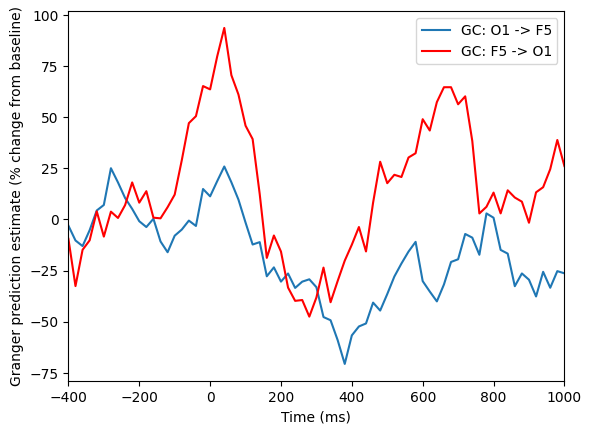

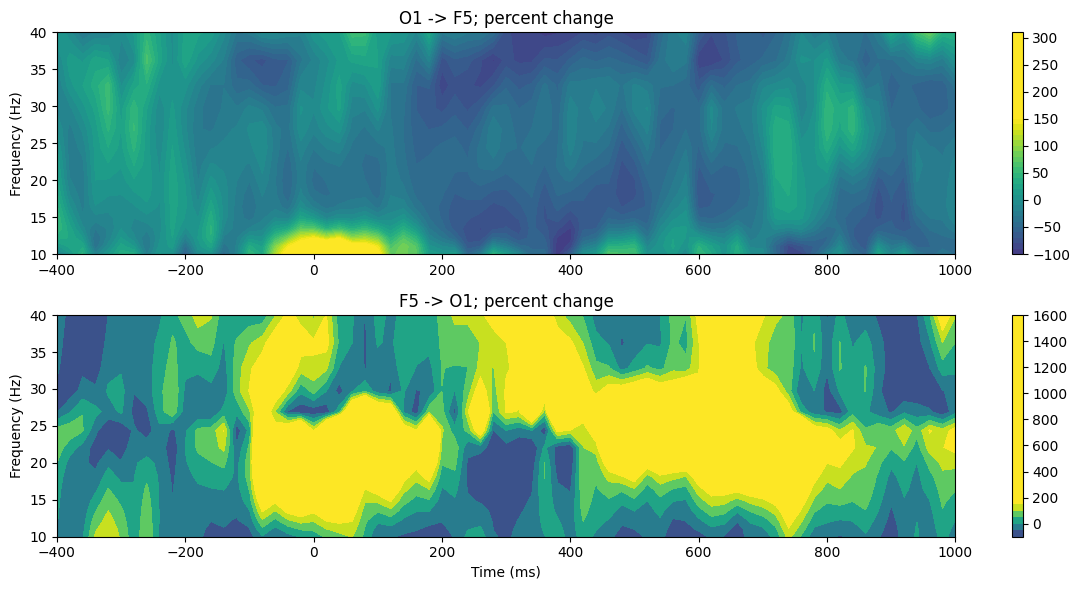

In [9]:
# Baseline time window
baseline_period = [-400, -100]

# Convert to indices
baseidx = [np.argmin(np.abs(times2save - bp)) for bp in baseline_period]

# Plot as % changes from baseline
plt.figure()
plt.plot(times2save, 100 * (x2y - np.mean(x2y[baseidx[0]:baseidx[1]+1])) / np.mean(x2y[baseidx[0]:baseidx[1]+1]), label=f'GC: {chan1name} -> {chan2name}')
plt.plot(times2save, 100 * (y2x - np.mean(y2x[baseidx[0]:baseidx[1]+1])) / np.mean(y2x[baseidx[0]:baseidx[1]+1]), 'r', label=f'GC: {chan2name} -> {chan1name}')
plt.legend()
plt.xlim([-400, 1000])
plt.xlabel('Time (ms)')
plt.ylabel('Granger prediction estimate (% change from baseline)')

plt.show()


# Convert time-frequency domain to percent change
tf_grangerPC = tf_granger.copy()
for i in range(2):
    meangranger = np.mean(tf_grangerPC[i, :, baseidx[0]:baseidx[1]+1], axis=1)
    tf_grangerPC[i, :, :] = 100 * (tf_grangerPC[i, :, :] - meangranger[:, None]) / meangranger[:, None]

# Plot time-frequency Granger causality percent change
plt.figure(figsize=(12, 6))
for i in range(2):
    plt.subplot(2, 1, i+1)
    plt.contourf(times2save, frequencies, tf_grangerPC[i, :, :], 40, cmap='viridis', vmin=-150, vmax=150)
    plt.colorbar()
    if i == 0:
        plt.title(f'{chan1name} -> {chan2name}; percent change')
    else:
        plt.title(f'{chan2name} -> {chan1name}; percent change')
    plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

### Figure 28.9

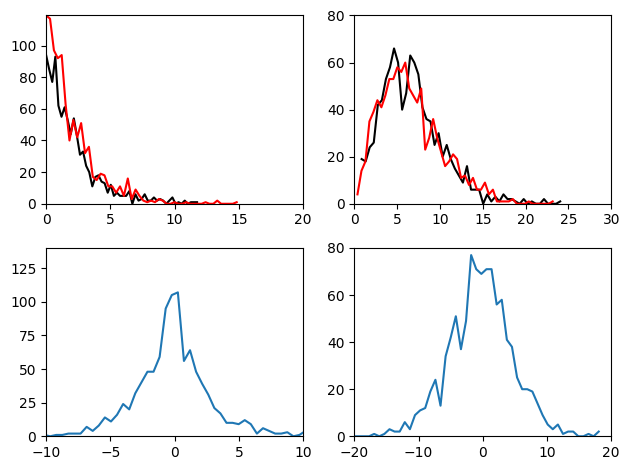

In [10]:
plt.figure()

# Generate two chi-square distributed random numbers
d1 = chi2.rvs(2, size=1000)
d2 = chi2.rvs(2, size=1000)

# Get histograms
y1, x1 = np.histogram(d1, bins=50)
y2, x2 = np.histogram(d2, bins=50)
y3, x3 = np.histogram(d1 - d2, bins=50)

plt.subplot(221)
plt.plot(x1[:-1], y1, 'k')
plt.plot(x2[:-1], y2, 'r')
plt.xlim([0, 20])
plt.ylim([0, max(y1.max(), y2.max())])

plt.subplot(223)
plt.plot(x3[:-1], y3)
plt.xlim([-10, 10])
plt.ylim([0, 140])

# Once more, with new distributions
d1 = chi2.rvs(7, size=1000)
d2 = chi2.rvs(7, size=1000)

# Get histograms
y1, x1 = np.histogram(d1, bins=50)
y2, x2 = np.histogram(d2, bins=50)
y3, x3 = np.histogram(d1 - d2, bins=50)

plt.subplot(222)
plt.plot(x1[:-1], y1, 'k')
plt.plot(x2[:-1], y2, 'r')
plt.xlim([0, 30])
plt.ylim([0, 80])

plt.subplot(224)
plt.plot(x3[:-1], y3)
plt.xlim([-20, 20])
plt.ylim([0, 80])

plt.tight_layout()
plt.show()